In [21]:
import os,sys, re
from importlib import reload
import numpy as np
import pandas as pd
from Bio.Seq import reverse_complement
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")


from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame
#import MERFISH_probe_design.probe_design.OTTable_dict as ot

1394690


In [22]:
from ChromAn.src.file_io.data_organization import Color_Usage, search_fovs_in_folders, color_usage_kwds

In [23]:
import ChromAn
reload(ChromAn.src.file_io.data_organization)
from ChromAn.src.file_io.data_organization import Data_Organization, search_fovs_in_folders
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [31]:
# where the original data saves
data_home =  r"/lab/weissman_imaging/puzheng"
data_folder = os.path.join(data_home, '4T1Tumor', '20240201-F168_MF4amplify')

experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_MF4_amplified.csv')
print(os.path.isfile(color_usage_filename))

20240201
True


In [28]:
os.listdir(data_folder)

['H0M1',
 'H1M2',
 'H2M3',
 'H3M4',
 'H4M5',
 'H5M6',
 'H6M7',
 'Analysis',
 'Experiment',
 'Tests',
 'Mosaics']

In [29]:
# visualize some images:
folders, fovs = search_fovs_in_folders(data_folder)
sel_fov = 50

test_ref_filename = os.path.join(folders[0], fovs[sel_fov])
test_filename = os.path.join(folders[1], fovs[sel_fov])
# load ref
daxp_ref = DaxProcesser(test_ref_filename)
daxp_ref._load_image()
#daxp_ref._corr_hot_pixels()
# load
daxp = DaxProcesser(test_filename)
daxp._load_image()
#daxp._corr_hot_pixels()
daxp._calculate_drift(RefImage=daxp_ref.im_477, FiducialChannel='477')

- searching in folder: /lab/weissman_imaging/puzheng/4T1Tumor/20240201-F168_MF4amplify
-- 7 folders, 107 fovs detected.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240201-F168_MF4amplify/H0M1/Conv_zscan_050.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240201-F168_MF4amplify/H0M1/Conv_zscan_050_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['748', '637', '545', '477', '405'] in 17.062s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240201-F168_MF4amplify/H1M2/Conv_zscan_050.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240201-F168_MF4amplify/H1M2/Conv_zscan_050_processed.hdf5
-- all used channels: ['748', '637', '545', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['748', '637', '545', '477'] in 4.274s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given sour

(array([0.        , 2.06      , 3.05666667]), 1)

### Quickly visualize bead image to find bead-localizing z-frame

<IPython.core.display.Javascript object>


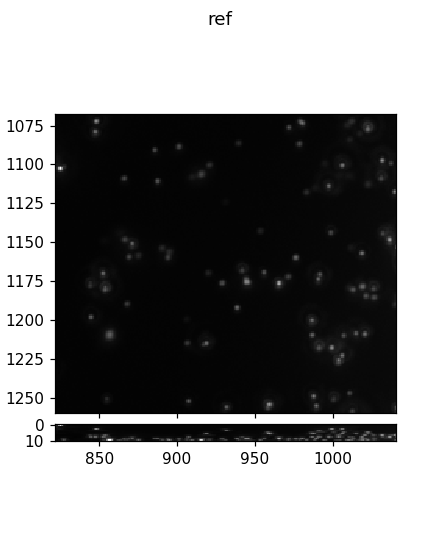

In [30]:
%matplotlib notebook
imshow_mark_3d([daxp.im_477, daxp_ref.im_477], image_names=['im', 'ref'])

<IPython.core.display.Javascript object>


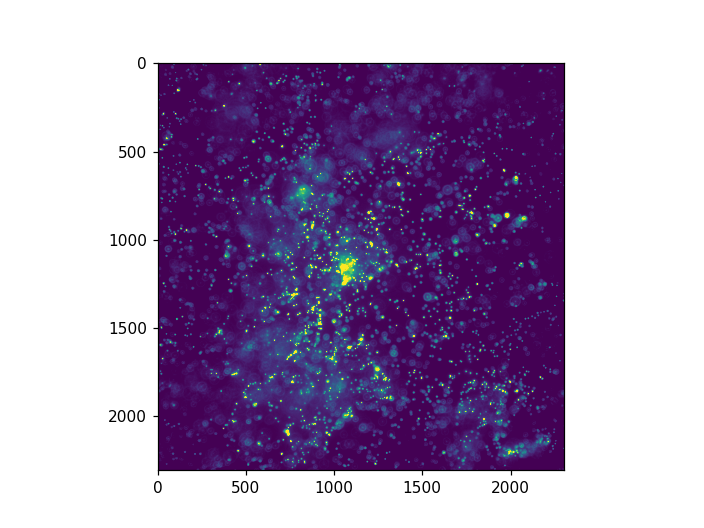

In [32]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(daxp_ref.im_477[10], vmin=500, vmax=5000)

<IPython.core.display.Javascript object>


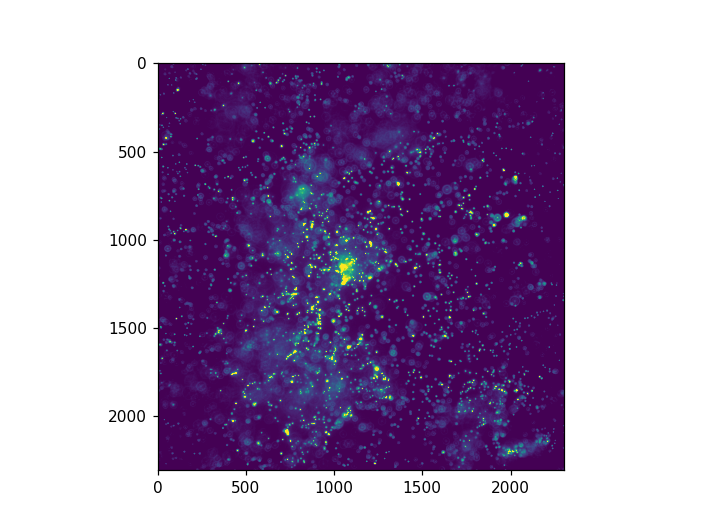

In [33]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(daxp.im_477[10], vmin=500, vmax=5000)

In [34]:
ref_Zstep = 10 # start from 0, manually check several images

In [35]:
# Load readout names:
library_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit'
readout_filename = os.path.join(library_folder, 'readouts.csv')

if os.path.exists(readout_filename):
    readouts = pd.read_csv(readout_filename) 
else:
    # generate readout_file
    import MERFISH_probe_design.IO.file_io as fio
    merfish_bits_file = os.path.join(r'/lab/solexa_weissman/puzheng/References/Readouts', 'MERFISH_readouts.fasta')
    merfish_bits = fio.load_fasta_into_df(merfish_bits_file)
    # first 22 bits are for this library:
    readouts = {'Name':[_id.split('-')[-1] for _id in merfish_bits.loc[:, 'id']], 
                'Sequence':merfish_bits.loc[:, 'sequence']}
    readouts = pd.DataFrame(readouts)
    # save this readout
    readouts.to_csv(readout_filename, index=None)
# select names
readout_names = list(readouts['Name'])
print(len(readout_names))

16


In [36]:
color_usage_filename

'/lab/weissman_imaging/puzheng/4T1Tumor/20240201-F168_MF4amplify/Analysis/color_usage_MF4_amplified.csv'

In [37]:
# Generate data organization
data_organization_filename = f'../../merlin_parameters/dataorganization/{experiment_date}-MF4_{len(readout_names)}bit.csv'
_do = Data_Organization(data_organization_filename,)
if _do.is_empty():
    # create
    _do.create_from_colorUsage(color_usage_filename, data_folder,ref_Zstep, readout_names=readout_names)
    # save
    _do.save_to_file(overwrite=True)

- load color_usage from file: /lab/weissman_imaging/puzheng/4T1Tumor/20240201-F168_MF4amplify/Analysis/color_usage_MF4_amplified.csv
- searching in folder: /lab/weissman_imaging/puzheng/4T1Tumor/20240201-F168_MF4amplify
-- 7 folders, 107 fovs detected.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
- 16 MERFISH rows appended.
- PolyT row appended.
- DAPI row appended.
Saving data_organization into file: ../../merlin_parameters/dataorganization/20240201-MF4_16bit.csv.


In [38]:
ref_image_type = '748_637_477_405_s11' # ref 58 / 65
polyt_image_type = '637_477_s11'
image_type = '748_637_477_s11' # ref 36/39

In [39]:
_do

,channelName,readoutName,imageType,imageRegExp,bitNumber,imagingRound,color,frame,zPos,fiducialImageType,fiducialRegExp,fiducialImagingRound,fiducialFrame,fiducialColor
0,bit1,b1-RS0015,748_637_545_477_405_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,0,748,[0 5 10 15 20 25 30 35 40 45 50],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_405_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,0,53,477
1,bit2,b2-RS0083,748_637_545_477_405_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,0,637,[1 6 11 16 21 26 31 36 41 46 51],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_405_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,0,53,477
2,bit3,b3-RS0095,748_637_545_477_405_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,0,545,[2 7 12 17 22 27 32 37 42 47 52],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_405_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,0,53,477
3,bit4,b4-RS0109,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,4,1,748,[0 4 8 12 16 20 24 28 32 36 40],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,43,477
4,bit5,b5-RS0175,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,5,1,637,[1 5 9 13 17 21 25 29 33 37 41],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,43,477
5,bit6,b6-RS0237,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,6,1,545,[2 6 10 14 18 22 26 30 34 38 42],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,43,477
6,bit7,b7-RS0247,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,7,2,748,[0 4 8 12 16 20 24 28 32 36 40],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,43,477
7,bit8,b10-RS0332,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,8,2,637,[1 5 9 13 17 21 25 29 33 37 41],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,43,477
8,bit9,b11-RS0343,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,9,2,545,[2 6 10 14 18 22 26 30 34 38 42],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,43,477
9,bit10,b12-RS0384,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,10,3,748,[0 4 8 12 16 20 24 28 32 36 40],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,748_637_545_477_s11,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,43,477


## Copy position file

In [40]:
from shutil import copyfile

In [41]:
position_filename = os.path.join(data_folder, 'Experiment', 'positions_all.txt')

target_position_filename = os.path.join(r"../../merlin_parameters/positions/", f"{experiment_date}_positions.txt")

if os.path.isfile(position_filename):
    print(f"source position file: {position_filename}")
    print(f"target position file: {target_position_filename}")
    # copy
    copyfile(position_filename, target_position_filename)
else:
    print(f"position file doesn't exist. Check this directory: {position_filename}")

source position file: /lab/weissman_imaging/puzheng/4T1Tumor/20240201-F168_MF4amplify/Experiment/positions_all.txt
target position file: ../../merlin_parameters/positions/20240201_positions.txt
